In [1]:
import os, tempfile
import logging
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:290: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:306: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:290: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:306: SyntaxWarning: assertion is always true, perhaps remove parentheses?


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.isus_wang import (wang_act_and_kin,
                                   wang_inact)
from experiments.isus_courtemanche import (courtemanche_inact_kin,
                                           courtemanche_deact)
from experiments.isus_firek import (firek_inact)
from experiments.isus_nygren import (nygren_inact_kin,
                                     nygren_rec)

In [5]:
modelfile = 'models/courtemanche_isus.mmt'

## Plot steady-state and tau functions

In [6]:
from ionchannelABC.visualization import plot_variables

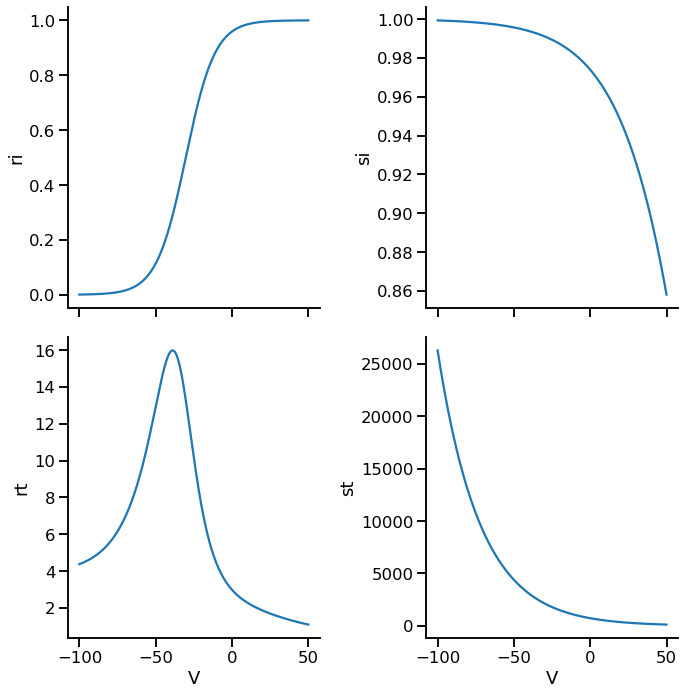

In [7]:
sns.set_context('talk')

V = np.arange(-100, 50, 0.01)

cou_vars = {'ri': 'isus.a_inf',
            'si': 'isus.i_inf',
            'rt': 'isus.tau_a',
            'st': 'isus.tau_i'}

f, ax = plot_variables(V, cou_vars, modelfile, figshape=(2,2))

## i gate -> Inactivation data only

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                firek_inact,
                                                nygren_inact_kin,
                                                nygren_rec)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

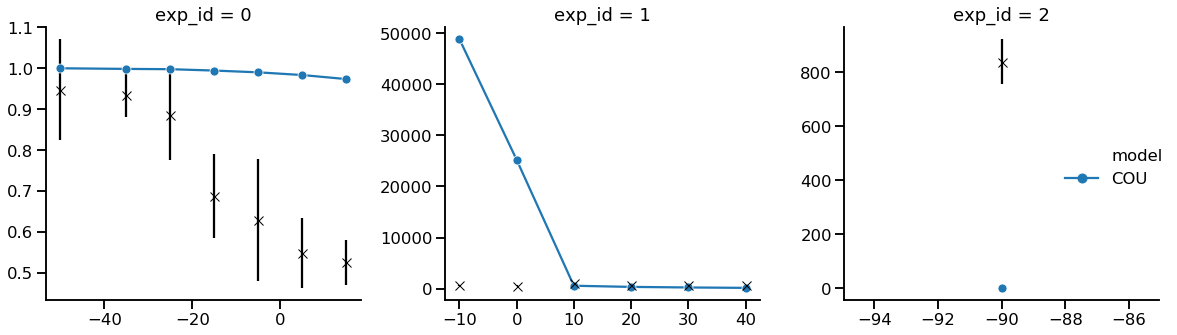

In [10]:
g = plot_sim_results(modelfile,
                     firek_inact,
                    nygren_inact_kin,
                    nygren_rec)

In [11]:
limits = {'isus.q1': (-200, 200),
          'isus.q2': (1e-7, 50),
          'log_isus.q3': (-1, 4),
          'isus.q4': (-200, 200),
          'isus.q5': (1e-7, 50),
          'isus.q6': (-200, 0),
          'isus.q7': (1e-7, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [12]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_isus_igate_full.db"))

In [13]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 128 particles


In [14]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

In [15]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [16]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=4, start_time=2019-10-28 17:30:55.055210, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
INFO:ABC:t:1 eps:3.779602733664772


### Database results analysis

In [18]:
history = History(db_path)

In [19]:
df, w = history.get_distribution()

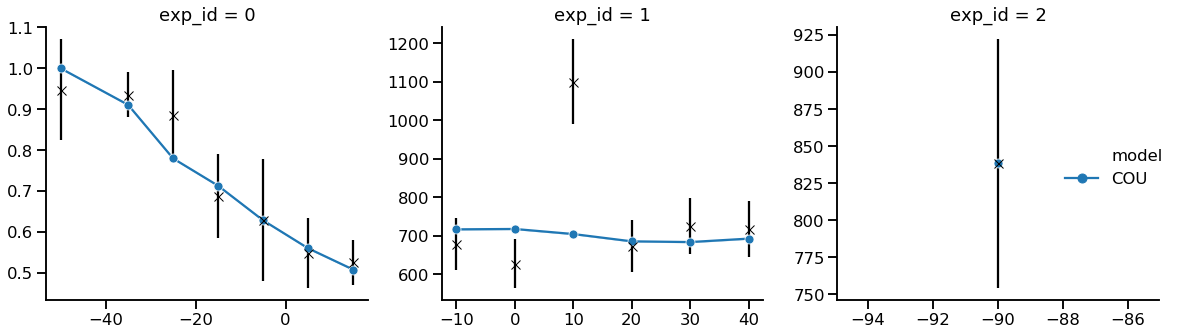

In [20]:
g = plot_sim_results(modelfile,
                     firek_inact,
                    nygren_inact_kin,
                    nygren_rec,
                     df=df, w=w)

In [21]:
cou_pars = df.sample(n=100, weights=w, replace=True)
cou_pars = cou_pars.set_index([pd.Index(range(100))])
cou_pars = cou_pars.to_dict(orient='records')

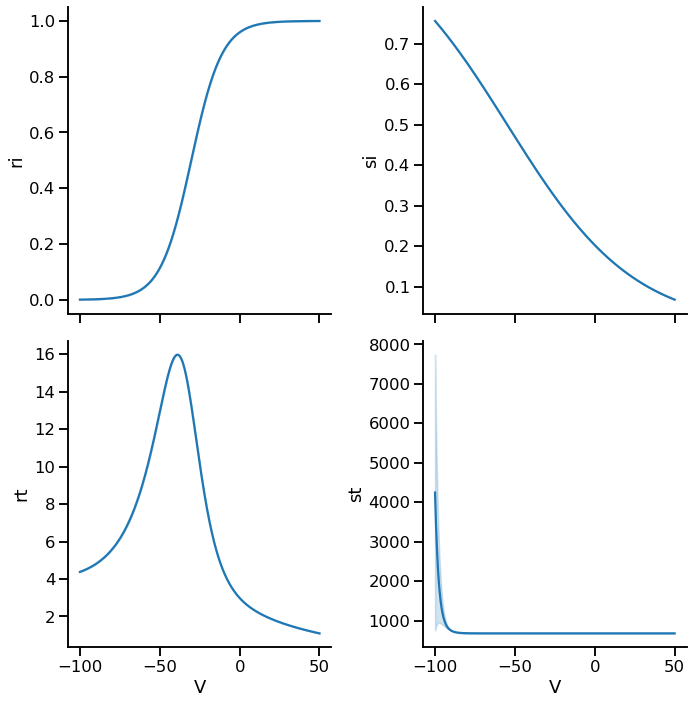

In [22]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, cou_vars, 
                       'models/courtemanche_isus.mmt', 
                       [cou_pars],
                       figshape=(2,2))

In [23]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [24]:
m,_,_ = myokit.load(modelfile)

In [25]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

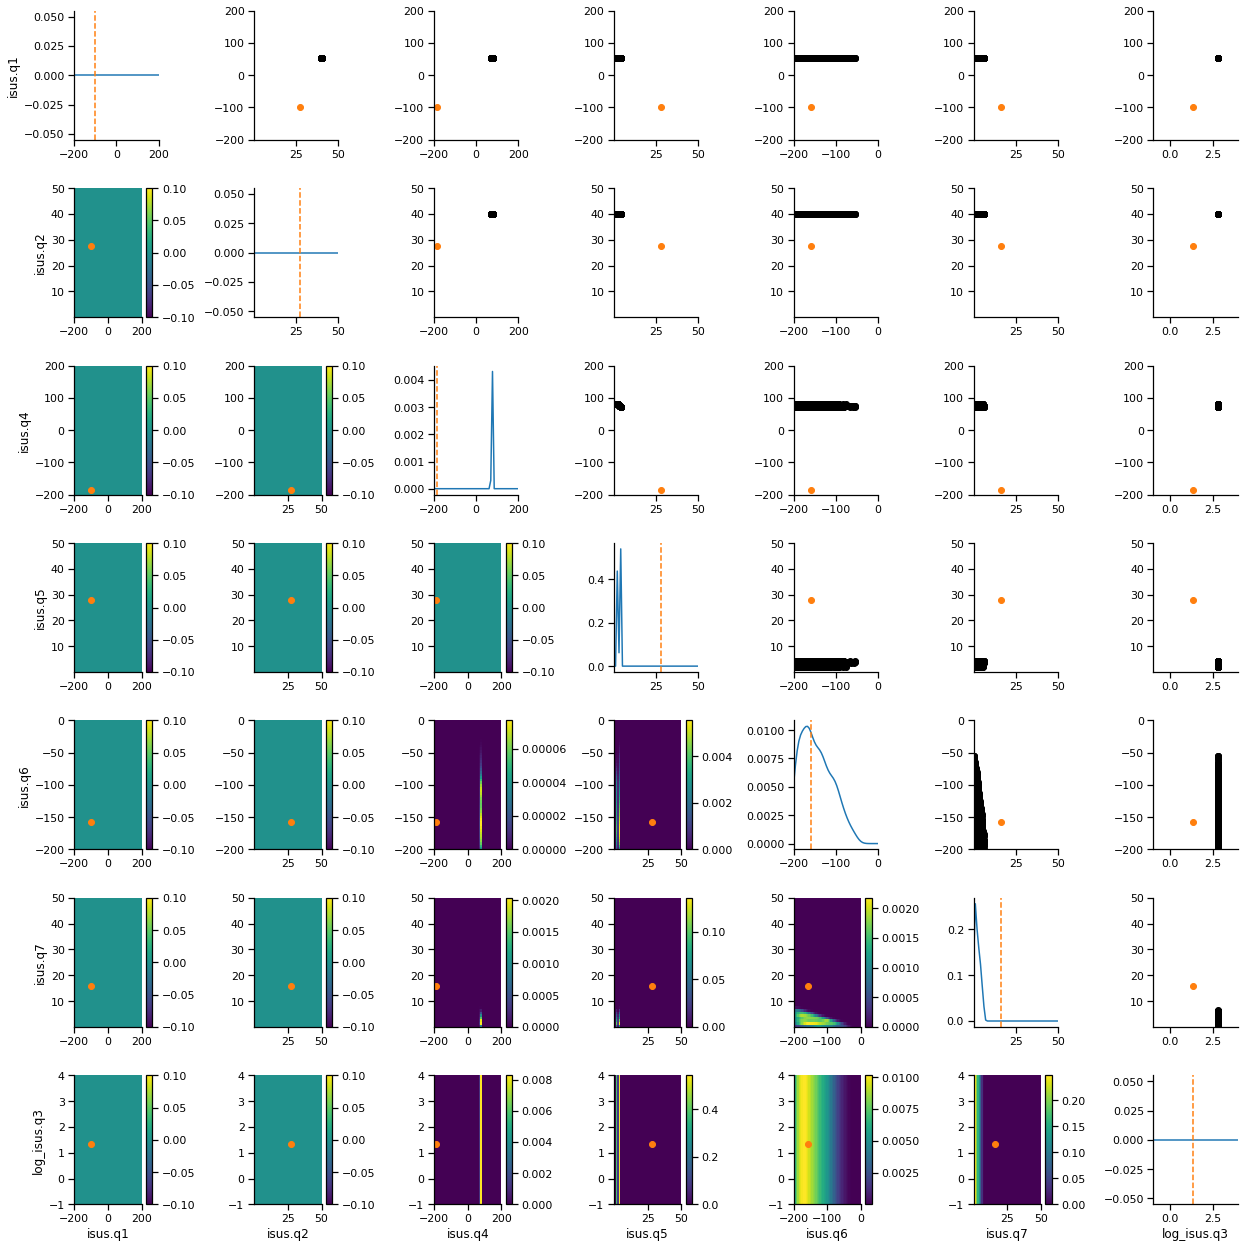

In [26]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)